In [14]:
from numpy import *



def loadSimpData():
    datMat = matrix([[1, 2.1],
                    [2, 1.1],
                    [1.3, 1],
                    [1, 1],
                    [2, 1],
                    ])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    '''
    单层决策树分类函数,返回列向量，1和-1
    '''
    retArray = ones((shape(dataMatrix)[0], 1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

def buildStump(dataArr, classLabels, D):
    '''
    找到数据集上最佳的单层决策树，输入D为权重列；返回字典，最小误差，最佳预测结果那一列
    '''
    dataMatrix = mat(dataArr)
    labelMat = mat(classLabels).T
    m, n = shape(dataMatrix)
    numSteps = 10.0
    bestStump = {}
    bestClasEst = mat(zeros((m, 1)))
    minError = inf
    #对于每一个特征
    for i in range(n):
        rangeMin = dataMatrix[:, i].min()
        rangeMax = dataMatrix[:, i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        #对于每个步长
        for j in range(-1, int(numSteps) + 1):
            #对于每个不等号
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = mat(ones((m, 1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    '''
    使用AdaBoost提升弱分类器性能，把最佳决策树加入到列表中
    返回单层决策树列表
    '''
    dataArr = mat(dataArr)
    classLabels = mat(classLabels)
    weakClassArr = []
    m = dataArr.shape[0]
    D = mat(ones((m, 1)) / m)
    aggClassEst = mat(zeros((m, 1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        print("D: {}".format(D.T))
        alpha = float(0.5 * log((1.0 - error) / max(error, 1e-16)))  #确保error为0时不会发生除0溢出
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        print(f"classEst: {classEst}")
        expon = multiply(-1 * alpha * mat(classLabels).T, classEst)
        D = multiply(D, exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst  #计算类别估计累计值
        print("aggClassEst: {}".format(aggClassEst.T))
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T, ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print("错误率为： {}".format(errorRate), '\n')
        if errorRate == 0:
            break
    return weakClassArr, aggClassEst

def adaClassify(datToClass, classifierArr):
    '''
    输入数据矩阵，多个弱分类器的列表
    返回预测值
    '''
    dataMatrix = mat(datToClass)
    m = dataMatrix.shape[0]
    aggClassEst = mat(zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], \
                                classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return sign(aggClassEst)

def loadDataSet(fileName):
    '''
    常规加载数据，返回的是列表
    '''
    numFeat = len(open(fileName).readline().split("\t"))  #readline读取接下来的一行，返回的是字符串
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

def plotROC(predStrengths, classLabels):
    '''
    画ROC曲线
    '''
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)
    ySum = 0.0
    numPosClas = sum(array(classLabels) == 1.0)  #正例个数
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    print(">>>>>>>>>>>>>>>>>>>>>>predStrengths: ", repr(predStrengths))
    sortedIndicies = predStrengths.argsort()
    print(">>>>>>>>>>>>>>>>>>>>>>>sortedIndicies: ", repr(sortedIndicies))
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    print('>>>>>>>>>>>>>>>>>>>>>>>>sortedIndicies: ', repr(sortedIndicies.tolist()))
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1] - delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True positive Rate')
    plt.title("ROC curve for AdaBoost Horse Colic Detection System")
    ax.axis([0,1,0,1])
    plt.show()
    print('AUC is: {}'.format(ySum * xStep))

In [2]:
dataMat, labelMat = loadDataSet('horseColicTraining2.txt')

In [3]:
weakClassArr, aggClassEst = adaBoostTrainDS(dataMat, labelMat, numIt=10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00223347 0.01306294 0.00128204 0.00562309 0.00295293 0.00128204
  0.00128204 0.00562309 0.00223347 0.00572819 0.00331691 0.00227522
  0.00128204 0.00819758 0.00208151 0.00223347 0.00119553 0.0019051
  0.00227522 0.00619658 0.00572819 0.00128204 0.00128204 0.0014278
  0.00208151 0.00338093 0.00331691 0.00186902 0.0097902  0.00080454
  0.00119553 0.00562309 0.00227522 0.00227522 0.0083508  0.00119553
  0.0055166  0.00671554 0.00128204 0.0055166  0.00119553 0.00338093
  0.00331691 0.00355906 0.0019051  0.00119553 0.0156008  0.00128204
  0.00300993 0.00119553 0.00128204 0.00819758 0.00128204 0.0019051
  0.00300993 0.00562309 0.0019051  0.00325605 0.00212169 0.00119553
  0.00128204 0.00227522 0.00295293 0.00479636 0.00331691 0.00208151
  0.00266739 0.00128204 0.00355906 0.00128204 0.00378409 0.00128204
  0.0055166  0.00309309 0.0097902  0.00562309 0.00117289 0.00080454
  0.00396369 0.00425051 0.00223347 0.00128204 0.00331691 0.0014278
  0.00227522 0.00128204 0.00223347 0.0097902  0.0

>>>>>>>>>>>>>>>>>>>>>>predStrengths:  matrix([[-0.646419  ,  0.53886223,  0.91726555,  0.21712009, -0.69768794,
          1.22181293,  1.22748297,  0.58145314, -0.40165729,  0.03508613,
          0.27123572,  0.59407783,  1.53203035,  0.64819347,  1.04739323,
         -0.40165729, -1.02662219,  0.5606821 ,  0.34364609, -0.40784481,
         -0.02469954,  1.53203035,  1.1676973 ,  1.0995114 ,  0.73717581,
          0.23749438,  0.52166747,  0.85052522,  0.5606821 ,  1.69342306,
         -1.02662219, -0.03331166,  0.95841088,  0.6538635 , -0.40165729,
         -1.58160132, -0.32315478, -0.69921001,  1.22748297,  0.23749438,
         -1.58160132,  0.23749438, -0.03331166, -0.49069632, -0.81111385,
         -1.58160132, -1.27705394,  1.22748297, -0.10329743, -1.33116957,
          0.91726555,  0.59407783,  0.91726555,  0.5606821 ,  0.20691998,
          0.27123572,  0.5606821 , -0.02469954, -0.70343447, -1.58160132,
          1.1676973 ,  0.95841088, -0.37284836, -0.19233647,  0.21712009,


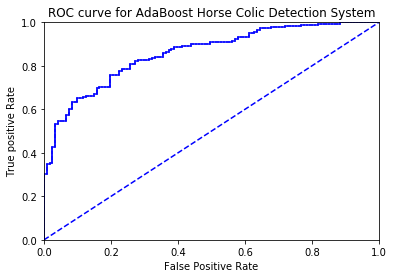

AUC is: 0.8582969635063604


In [15]:
%matplotlib inline
plotROC(aggClassEst.T, labelMat)